In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy 
import os
import re
from collections import OrderedDict
import itertools
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [2]:
dm_identifier = {
                'mnist': 'MNIST', 
                'cifar10': 'CIFAR-10', 
                'twenty_newsgroups': '20 Newsgroups',
                'tiny_imagenet': 'Tiny-ImageNet'
                }

directory_path_to_read = "../outputs/final_results/final_results_to_tex_table"

# Calibration method identifers
cms_ = OrderedDict({'None': 'Softmax',
                    'temp_scaling': 'TS',
                    'dirichlet': 'Dirichlet',
                    'scaling_binning': 'SB',
                    'histogram_binning_top_label': 'Top-HB',
                    'auto_label_opt_v0': 'Ours'
                    })
# Train-time method identifiers
ttms_ = OrderedDict({'std_cross_entropy': 'Vanilla',
                     'crl': 'CRL', 
                     'fmfp': 'FMFP', 
                     'squentropy': 'Squentropy'})

In [3]:
# This function traverses a directory and reads all xlsx files into dataframe
def helper_find_files_and_read_dataframe(root_path, patterns=[r"cifar10"]):
    dm_df= OrderedDict((dm, None) for dm in dm_identifier.keys()) 
    for root, _, files in os.walk(root_path):
        for filename in files:
            filepath = os.path.join(root, filename)
            if os.path.isfile(filepath) and filepath.endswith(".xlsx"):
                for pattern in patterns:
                    if re.search(pattern, filename, re.IGNORECASE):
                        if pattern in dm_df:
                            dm_df[pattern] = pd.concat([dm_df[pattern], pd.read_excel(filepath, sheet_name=0).drop(columns=['Unnamed: 0'])], axis=0)
                        else:
                            dm_df[pattern] = pd.read_excel(filepath, sheet_name=0).drop(columns=['Unnamed: 0']).copy(deep=True)
                        break 
    return dm_df 

# This function filters the dataframes that are stored
def read_and_get_filtered_dataframes(root_path, patterns=[r"cifar10"]):
    dm_df = helper_find_files_and_read_dataframe(root_path, patterns = patterns)
    # Apply filter to all dataframes
    for dm, df in dm_df.items():
        if df is None:
            continue
        df1 = copy.copy(df) # Shallow copy to new dataframe
        df1['calib_conf'] = df1['calib_conf'].fillna("None")
        df1['calib_conf'] = df1['calib_conf'].astype(str)
        # Sort by col: Coverage-Mean in descending order, and then by col: calib_conf in ascending order
        df2 = df1.sort_values(["Coverage-Mean", "calib_conf"], ascending = [False, True]).copy(deep=True)
        # Retain the first row for each unique value in col: calib_conf
        df3 = df2.drop_duplicates(subset=['calib_conf', 'training_conf'], keep='first').copy(deep=True)
        dm_df[dm] = df3
    return dm_df 

In [4]:
dm_df = read_and_get_filtered_dataframes( root_path = f"{directory_path_to_read}", patterns = dm_identifier.keys())

In [5]:
dm_df['mnist'].head()

,calib_conf,training_conf,C_1,N_t,N_v,N_hyp_v,Auto-Labeling-Err-Mean,Coverage-Mean,Avg-ECE-Val-Mean,Auto-Labeling-Err-Std,...,training_conf.optimizer,training_conf.reg,training_conf.weight_decay,training_conf_g.batch_size,training_conf_g.max_epochs,training_conf_g.optimizer,training_conf_g.weight_decay,weight_decay,rank_target,rank_weight
1,auto_label_opt_v0,squentropy,0.25,500,500,500,4.0683,97.2000,80.2390,0.7505,...,NaN,NaN,NaN,64.0,500.0,adam,1.0,0.001,NaN,NaN
0,auto_label_opt_v0,std_cross_entropy,0.25,500,500,500,4.3838,96.9396,77.3820,1.0148,...,NaN,NaN,NaN,64.0,500.0,adam,1.0,0.010,NaN,NaN
3,histogram_binning_top_label,squentropy,0.25,500,500,500,5.2956,96.3758,15.1037,0.4431,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001,NaN,NaN
2,dirichlet,squentropy,0.25,500,500,500,6.7333,95.9698,14.6366,1.6107,...,NaN,0.01,NaN,NaN,NaN,NaN,NaN,0.001,NaN,NaN
1,temp_scaling,std_cross_entropy,0.25,500,500,500,6.8583,95.7729,7.5169,0.5943,...,adam,NaN,0.01,NaN,NaN,NaN,NaN,0.010,NaN,NaN


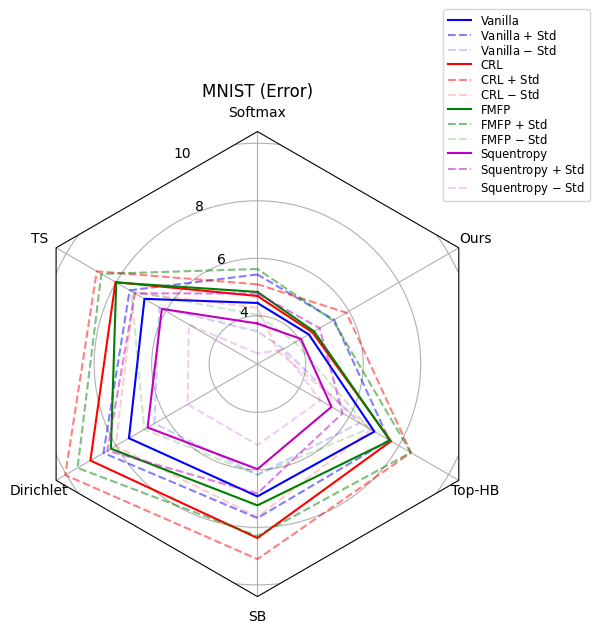

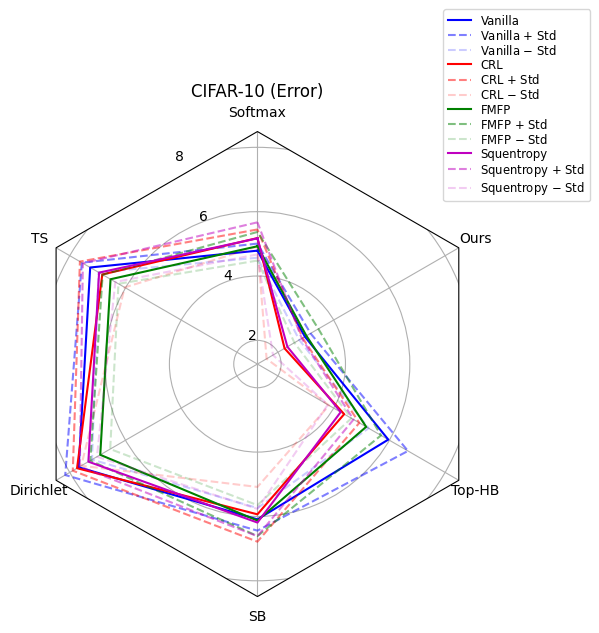

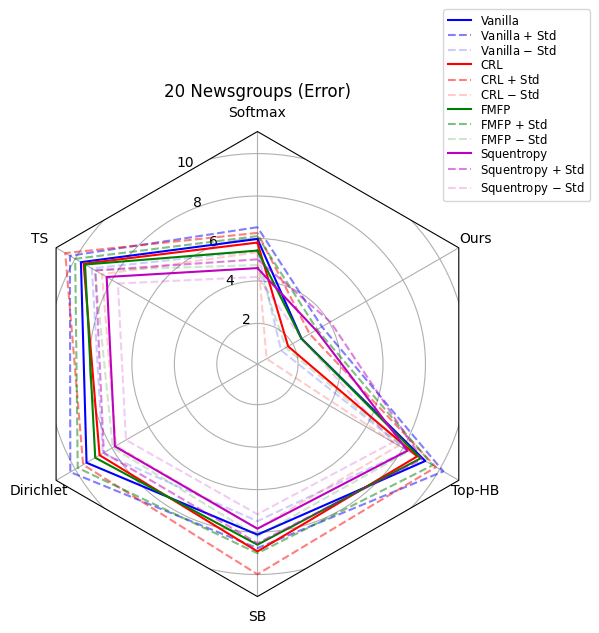

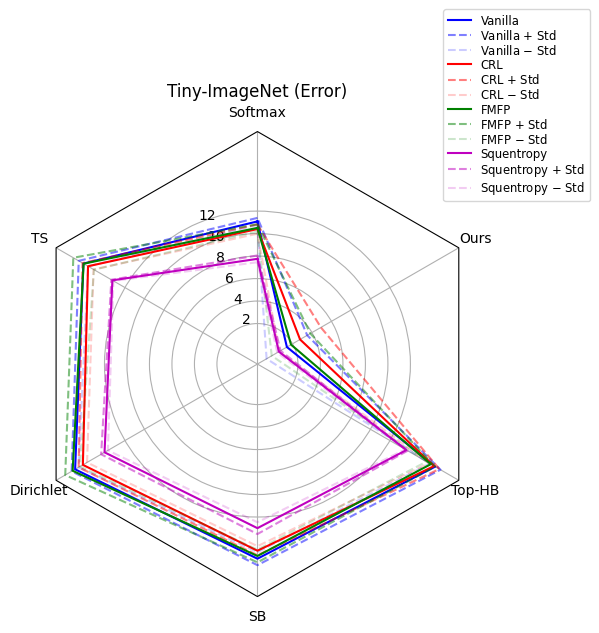

In [15]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)


                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta



for dm, df in dm_df.items():
    mat = []
    mat_std = []
    for tm in ttms_.keys():
        t_mat = []
        t_mat_std = []
        for cm in cms_.keys():
            mean_val = df[(df['training_conf'] == tm) & (df['calib_conf'] == cm)]['Auto-Labeling-Err-Mean'].values[0]
            std_val = df[(df['training_conf'] == tm) & (df['calib_conf'] == cm)]['Auto-Labeling-Err-Std'].values[0]
            t_mat.append(mean_val)
            t_mat_std.append(std_val)
        mat.append(t_mat)
        mat_std.append(t_mat_std)
    data = [cms_.values(),
            (f'{dm_identifier[dm]} (Error)', mat)]
    N = len(data[0])
    theta = radar_factory(N, frame='polygon')

    spoke_labels = data.pop(0)
    title, case_data = data[0]

    colors = ['b', 'r', 'g', 'm']
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(top=0.85, bottom=0.05)

    ax.set_rgrids([2, 4, 6, 8, 10, 12])
    ax.set_title(title,  position=(0.5, 1.1), ha='center')

    for d, cov, c in zip(case_data, mat_std, colors):
        line = ax.plot(theta, d, color=c)
        # ax.fill(theta, d,  alpha=0.25, facecolor=c)
        upper_bound = np.array(d) + np.array(cov)
        lower_bound = np.array(d) - np.array(cov)
        ax.plot(theta, upper_bound, color=c, linestyle='dashed', alpha=0.5)
        ax.plot(theta, lower_bound, color=c, linestyle='dashed', alpha=0.2)
    ax.set_varlabels(spoke_labels)

    # ttms_values = list(ttms_.values())
    # labels = [item for pair in zip(ttms_values, ttms_values, ttms_values) for item in pair]
    labels = ['Vanilla', 'Vanilla $+$ Std', 'Vanilla $-$ Std', 'CRL', 'CRL $+$ Std', 'CRL $-$ Std', 'FMFP', 'FMFP $+$ Std', 'FMFP $-$ Std', 'Squentropy', 'Squentropy $+$ Std', 'Squentropy $-$ Std']

    legend = ax.legend(labels, loc=(0.9, .85),
                              labelspacing=0.1, fontsize='small')

    plt.show()


In [7]:
# data = [['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
#         ('Basecase', [
#             [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
#             [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
#             [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
#             [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
#             [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]])]



# data = [cms_.values(),
#         ('Basecase', [
#             [0.88, 0.01, 0.03, 0.03, 0.00, 0.06],
#             [0.07, 0.95, 0.04, 0.05, 0.00, 0.02],
#             [0.01, 0.02, 0.85, 0.19, 0.05, 0.10],
#             [0.02, 0.01, 0.07, 0.01, 0.21, 0.12],
#             [0.01, 0.01, 0.02, 0.71, 0.74, 0.70]])]

# N = len(data[0])
# theta = radar_factory(N, frame='polygon')

# spoke_labels = data.pop(0)
# title, case_data = data[0]

# fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
# fig.subplots_adjust(top=0.85, bottom=0.05)

# ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
# ax.set_title(title,  position=(0.5, 1.1), ha='center')

# for d in case_data:
#     line = ax.plot(theta, d)
#     ax.fill(theta, d,  alpha=0.25)
# ax.set_varlabels(spoke_labels)

# plt.show()